In [0]:
import torch, os, ipywidgets, json
import torch.nn as nn
import numpy as np
import pandas as pd
import seaborn as sns
import torch.nn.functional as F
import torchvision as tv
import matplotlib.pyplot as plt
from google.colab import drive
from google.colab import widgets as clwidgets
from tqdm import tqdm_notebook as tqdm
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
PI = torch.tensor(np.pi, dtype=torch.float32)
sns.set_style('whitegrid')
%matplotlib inline

In [0]:
save_path = '/content/gdrive/My Drive/Tutorials/InfoGAN/MNIST/'
drive.mount('/content/gdrive', force_remount=True)
os.makedirs(os.path.join(save_path, 'ckpt'), exist_ok=True)

# A quick tour on Information Maximising Generative Adversarial Networks (InfoGAN)
*Yen Yu* $\diamond$ *yen.yu@araya.org* $\diamond$ *yen.yu.10@ucl.ac.uk*

*17/Jun/2019*



## Background
* This Notebook traces my steps from my only knowing about GAN on a conceptual level to actually trying to learn the theory behind by implementing it. 
* I intend this Notebook to be a tutorial accessible to those who wants to learn more about geneartive modelling (there is a plan to cover other GANs and VAE+Normalising Flows).

## Goal
* The goal of this Notebook is to to provide theoretical details of GAN just enough to motivate an implementation.
* The main focus will be on the implementation of InfoGAN
* To successfully train an InfoGAN on the MNIST dataset.

## References
[1] The origin GAN paper by Goodfellow

[2] The InfoGAN paper by Xi Chen

[3] Ferenc Huszar's [blog post](https://www.inference.vc/infogan-variational-bound-on-mutual-information-twice/)—very insightful

[4] [Useful GAN hacks (multiple authors)](https://github.com/soumith/ganhacks#authors)

## Classic GAN
### Theory
#### Layperson example

You are visiting a friend who is working in the packaging department of a factory. His/her job is to load the products onto a conveyer belt to initiate automatic packaging. You noticed, from the control room, that the conveyer belt has a layout resembling the shape of the letter Y. Products are loaded onto the branches on the top end and get merged into a single line at the junction in the middle. The packaging mechnism is located at the bottom end. An electronic gate at the junction controls which branch gets to pass. Whenever the indicator light on the gate shines red the left branch feeds into the bottom branch. And when a green light is shone, the opposite is the case.

You know the factory has a long-term partnership with a particular supplier who provides the standard products for this line. When the supply is short, the factory seeks additional supply from another supplier but thier quality can be a hit and miss.

Today, both branches are operating but you have no idea whether there has been a supply shortage. If there is a shortage, one of the branches must be carrying products of "somewhat questionable quality".

From the control room terminal, you see the gate camera view, along with its indicator light. Out of curiosity, you decide to challenge yourself to answer whether there *is* a shortage by finding out whether different lights signal a discernable impression on the product quality.

This time, you are positive because the non-standard products have a grey-ish tint.

Hopefully, on your next visit, knowing that there is still a shortage going on, you will find yourself having a hard time arriving at a definite conclusion. This can almost mean the additional supplier has boosted their quality to be on a par with the standard.

#### Remarks

* A Generative Adversarial Network (GAN) typically consists of a generator and a discriminator, both as trainable neural networks. The generator tries to generate samples to fool the discriminator, making it believe the generated samples are as good as the real ones. And the discriminator tries to unfool itself.
* The standard supplier provides the *real* data: $x_{real}$.
* The second supplier, which is the generator, provides the *fake* data: $x_{fake}$
* You, the discriminator, serve to differentiate the real from the fake. But you also help the fake fake better.
* The role of the indicator light $d$ will become clear in the following part.
* The layperson example lends itself to an information-theoretical interpretation as described below.

#### An information-theoretic perspective

Let us consider two random variables $x_{real}$ and $x_{fake}$, one representing data coming from a *real* distribution and another trying to mimic it. And $d \sim \mathrm{Bern}(0.5)$ being a mixing factor allows the following interaction:  

$$
\begin{align} 
x &= \left\{ 
    \begin{array}{l}
    x_{real},\; \hbox{ if } d=1 \\
    x_{fake},\; \hbox{ if } d = 0
    \end{array}
    \right.
\end{align}
$$

The task for a classic GAN is to make $x_{fake}$ as real as possible such that knowing $d$ provides minimal, if not none, insights into the actual identity of $x$. In the language of information theory, this is equivalent to saying

$$\min I(x : d)$$

The learning rule of the classic GAN can be derived from here by considering:

$$
\begin{align}
I(x : d) &= H(d) - H(d | x)  \\
    &= H(d) + \mathbb E_x \mathbb E_{d|x} \log p(d|x)  \\
    &= H(d) + \mathbb E_{d,x} \frac {\log p(d|x)} {\log q(d|x)} \log q(d|x)  \\
    &\ge H(d) + \mathbb E_{d,x} \log q(d|x)
\end{align}
$$

Here, an auxiliary density $q_{d|x}$ is introduced to create a lower bound on the mutual information. This bound is tight when $p(d|x) = q(d|x)$. Then the following holds:

$$
\begin{align}
I(x:d) &= H(d) + \max_{q_{d|x}} \mathbb E_{d,x} \log q(d|x)  \\
    &\ge H(d) + \max_\varphi \mathbb E_{d,x} \log q(d|x; \varphi)
\end{align}
$$

where the last line turns $q_{d|x}$ into a parametric family by assumption.

Then, one can expand the expectation to rewrite the expression since we knew $q$ is a coin-flip:

$$
\begin{align}
I(x:d) &\ge H(d) + \max_\varphi \left(  
  \mathbb E_{x_{real}} \log q(1 | x_{real};\varphi) +
  \mathbb E_{x_{fake}} \log q(0 | x_{fake}; \varphi)
  \right)
\end{align}
$$



### Implementation
Following the derivation immediately above, it becomes clear that we can treat the approximate density $q(d=\{0, 1\} | x; \varphi)$ as a deep neural network that works as a discriminator ($\mathcal D(x; \varphi)$) . Specifically, we want this D network to take as input, say, an image tensor and output a scalar between 0 and 1. This D network should be able to tell $x$ apart by learning to assign 1 to $x_{real}$ and 0 to $x_{fake}$:
$$
\begin{align}
&= H(d) + \max_\varphi \left( 
  \mathbb E_{x_{real}} \log \mathcal D(x_{real};\varphi) + 
  \mathbb E_{x_{fake}} \log [1 - \mathcal D(x_{fake}; \varphi)]
  \right) 
\end{align}
$$
On the other hand, $x_{fake}$ is something we have to create from nothing (well, from noise, to be exact). And we can assign this task to another neural network that we'd like to call the generator $\mathcal G(z; \vartheta)$, where $z$ is the noise vector. By replaceing $x_{fake}$ with $\mathcal D(z; \vartheta)$ we sidestep the need to actually evaluate the expectation $\mathbb E_{x_{fake}}$. Instead, we are now dealing with a much simpler $\mathbb E_z$, whcih can be Monte Carlo approximated:

$$
\begin{align}
&=H(d) + \max_\varphi \left( 
  \mathbb E_{x_{real}} \log \mathcal D(x_{real};\varphi) + 
  \mathbb E_{z} \log [1 - \mathcal D(\mathcal G(z; \vartheta); \varphi)]
  \right)
\end{align}
$$

where $\vartheta$ parametrises the generator network $\mathcal G$ and $z \sim N(0,1)$ is some Gaussian noise conventionally used by GAN.

The G network has to learn to fool the D network as the D network tries to tell the real and fake apart. This brings us back to our initial objective of minimising the mutual information. We can now write down the classic GAN objective:

$$
\begin{align}
\min_\vartheta \max_\varphi \left( 
  \mathbb E_{x_{real}} \log \mathcal D(x_{real};\varphi) + 
  \mathbb E_{z} \log [1 - \mathcal D(\mathcal G(z; \vartheta); \varphi)]
  \right)
\end{align}
$$


#### Task
To implement a classic GAN, we need to program the following:
* A discriminator network $\mathcal D$ that maps an input to a real number between 0 and 1 (as representing probability)
* A generator $\mathcal G$ that takes some noise vector of arbitrary dimension 
* Write down the objective function

In [0]:
%%script false
# This is only a demonstration cell

# Taks 1: Program a discriminator network
class Discriminator(nn.Module):
    """A Discriminator network represents a function 
    that maps an input to a scalar between (0, 1)."""
    def __init__(self):
        super(Discriminator, self).__init__()
        
        # The following contains the main component of the
        # desired function. It can take any valid architecture.
        # But for the sake of demonstration, I will only include 
        # minimal numbers of network layers, assuming the inputs
        # are mini-batches of MNIST images which are monochromatic,
        # 28x28 images.
        self.layers = nn.Sequential(
            # NB. setting bias=False only because BN is used. The beta parameter
            # in a BN works just like a bias.
            nn.Conv2d(1, 64, (3, 3), stride=(2, 2), padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.1),
            nn.Conv2d(64, 128, (3, 3), stride=(2, 2), padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.1),
            nn.Conv2d(128, 1024, (7, 7), stride=(1, 1), padding=0, bias=False),
            nn.BatchNorm2d(1024)
            nn.LeakyReLU(0.1),
            nn.Conv2d(1024, 1, (1, 1), stride=(1, 1), padding=0, bias=True),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        return self.layers(x)

# Task 2: Program a generator network
class Generator(nn.Module):
    """A Generator is a function that maps a latent code (usually a noise vector) of
    arbitrary dimension (here 74 is used) to a tensor that mimics real dataset."""
    def __init__(self):
        super(Generator, self).__init__()
        
        self.layers = nn.Sequential(
            nn.Conv2d(74, 1024, (1, 1), (1, 1), bias=False, padding=0),
            nn.LeakyReLU(0.1),
            nn.BatchNorm2d(1024),
            nn.ConvTranspose2d(1024, 128, (7, 7), (1, 1), bias=False, padding=0),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.1),
            nn.ConvTranspose2d(128, 64, (4, 4), (2, 2), bias=False, padding=1),
            nn.BatchNorm2d(64),
            nn.ConvTranspose2d(64, 1, (4, 4), (2, 2), bias=True, padding=1),
            nn.Sigmoid())

        self.apply(initialise_weights)
    
    def forward(self, x):
        return self.layers(x)

# Task 3: Write down the GAN loss
class ClassicGANCriterion:
    def __call__(self, prob, label):
        prob = prob.view(-1)
        label = torch.zeros_like(prob).fill_(label)
        return F.binary_cross_entropy(prob, label)

## InfoGAN


The classic GAN generator places no restrictions on how the noise vector should be used to generate data. It can inadvertently come to ignore a big part of that noise vector by essentially map a range of value to the same output. As a result, the generator will fail to capture the true data distribution and quite often end up with one with very low entropy. Naturally, a generator behaviing like this will do a very poor job in fooling the discriminator. This failure mode is marked by high generator loss and 0 discriminator loss, otherwise known as "mode collapse" of GAN.

The authors of InfoGAN attempted to prevent mode collapse by introducing one regulariser as restriction. This restriction is such that any generator output, give a noise vector, has to retain maximum information about that vector. This is the same as saying:

$$
\max I(z, x_{fake})
$$

InfoGAN does this by allowing a partition in the noise vector. In classic GAN, a noise vector can be as simple as $z \sim N(\boldsymbol{0}, Id)$, where $\boldsymbol{0}$ is a zero vector and $Id$ is an identity matrix of arbitrary dimension. InfoGAN chooses to have $z = \{ c, z'\}$, where $c$ is a noise vector from a known distribution whose sufficient statistics must be recovered after the generation process (in the form of posterior estimates, but more on that later!). Whereas, $z'$ is the same old noise vector ($z$) used by classic GAN, meaning there will be no restrictions placed on $z'$.

We can then rewrite the mutual information above to only include $c$, i.e., $I(c, x_{fake})$. For InforGAN, the following is to be minimised

$$
I(d, x) - \lambda I(c, x_{fake})
$$
where $\lambda$ serves to adjust scale (entropy and mutual information are not scale-invariant).

### Implementation
To see how this can be implemented using neural network, we trace our steps in the previous section and attempt a similar work on the newly introduced regulariser. We have

$$
\begin{align}
I(c, x_{fake}) &= H(c) - H(c | x_{fake})  \\
&= H(c) + \mathbb E_{z\sim p(z)} \mathbb E_{c \sim p(c)} \log p(c | x_{fake}) \\
&= H(c) + \mathbb E_{z, c} \log p(c | \mathcal G(c, z)) 
\end{align}
$$

If we create a variational lower bound just like we did earlier we would have a difficult time evaluating the log-probability in the second term. However, by Law of Total Expectation, we can now see this expression in a different light:

$$
\begin{align}
\mathbb E_{z, c} \log p(c |\mathcal G(c, z)) &= 
  \mathbb E_{z, c} \mathbb E_{c' \sim p(c'|x_{fake})} \log p(c' | \mathcal G (c, z)) \\
&= \mathbb E_{z, c} \mathbb E_{c' \sim p(c'|x_{fake})} \log \frac {p(c'|x_{fake})}{q(c'|x_{fake})} q(c'|x_{fake})  \\
&\ge \mathbb E_{z, c} \mathbb E_{c' \sim p(c'|x)} \log q(c'|x_{fake})
\end{align}
$$

This means we will use $c$ and $z$ to get our $x_{fake}$ through the generator $\mathcal G$. Then program a neural network as $q(c'|x_{fake})$—assuming a known family of probability distributions—that takes as input $x_{fake}$ and outputs the sufficient statistics of the approximate density $q_{c'|x_{fake}}$ (which is called a Recognition Model in the paper). There! We can work out the log-probability with much less effort.

#### Generator and utility objects
First, let us take care of the usual generator and we will get to the discriminator and recognition model after that. We have done this bit in the classic GAN section and there is nothing new in particular, only we have introduced a different normalisation module (which I might want to compare aginst BatchNorm later).

In [0]:
def initialise_weights(module):
    if isinstance(module, nn.Conv2d) or isinstance(module, nn.ConvTranspose2d):
        nn.init.xavier_normal_(module.weight.data)
        if isinstance(module.bias, torch.Tensor):
            module.bias.data.fill_(0.)


class GroupNorm2d(nn.Module):
    """Group Normalisation Layer."""
    def __init__(self, channels, groups, eps=1e-5):
        super(GroupNorm2d, self).__init__()
    
        self.gamma = nn.Parameter(torch.ones(1, channels, 1, 1))
        self.beta = nn.Parameter(torch.zeros(1, channels, 1, 1))
        self.num_groups = groups
        self.eps = eps

    def forward(self, x):
        N, C, H, W = x.size()
        G = self.num_groups

        x = x.view(N, G, -1)
        mean = x.mean(dim=2, keepdim=True)
        var = (x - mean).pow(2).sum(2, keepdim=True) / x.size(2)

        x = (x - mean) / (var + self.eps).sqrt()
        x = x.view(N, C, H, W)

        return x * self.gamma + self.beta


class Generator(nn.Module):
    """The Generator Network."""
    def __init__(self):
        super(Generator, self).__init__()
        # Network architecture follows the original InfoGAN paper (Chen et al.)
        self.layer = nn.Sequential(
            nn.Conv2d(74, 1024, (1, 1), (1, 1), bias=False, padding=0),
            nn.LeakyReLU(0.1),
            GroupNorm2d(1024, 32),
            nn.ConvTranspose2d(1024, 128, (7, 7), (1, 1), bias=False, padding=0),
            GroupNorm2d(128, 32),
            nn.LeakyReLU(0.1),
            nn.ConvTranspose2d(128, 64, (4, 4), (2, 2), bias=False, padding=1),
            GroupNorm2d(64, 32),
            nn.ConvTranspose2d(64, 1, (4, 4), (2, 2), bias=True, padding=1),
            nn.Tanh())

        self.apply(initialise_weights)
    
    def sample_latent(self, batch_size, device):
        # all dimension information is mentioned in the original InfoGAN paper
        # incompressible noise (z)
        z = torch.randn(batch_size, 62, device=device)

        # categorical latent code (cd)
        # c ~ Categ(K=10, p=0.1)
        index = torch.randint(0, 10, (batch_size,), device=device)
        cd = torch.zeros(batch_size, 10, device=device)
        cd[torch.arange(batch_size), index] = 1

        # continuous latent codes (cc)
        # c ~ Unif(-1., 1.)
        cc = torch.rand((batch_size, 2), device=device) * 2. - 1.

        noise = torch.cat([z, cd, cc], dim=1).view(-1, 74, 1, 1)
        return noise, index
    
    def forward(self, x):
        return self.layer(x)

#### Discriminator and Recognition model
Here, we have split the discriminator network into two parts (the "SharedNetwork" and "DiscriminatorEnd") and have one part shared with the Recognition model. This can be interpreted as using the Recognition model (which works as inferring the sufficient statistics of the seed noise vector) as an auxiliary task for the discriminator network. Auxiliary task tends to help obtain good representation. The same technique is also seen in reinforcement learning. We also attached another network to the discriminator to classify images from the true dataset which seems to help stablise training.

In [0]:
class SharedNetwork(nn.Module):
    """Network shared between the Discriminator and Recognition model."""
    def __init__(self):
        super(SharedNetwork, self).__init__()
        
        # Average pooling is used here in place of the usual max pooling or strides
        # Empirically, this avoids sparse gradients and tends to prevent mode collapse.
        self.net_base = nn.Sequential(
            nn.Conv2d(1, 64, (4, 4), (1, 1), bias=False, padding=0),
            nn.LeakyReLU(0.1),
            nn.AvgPool2d((2, 2)),
            GroupNorm2d(64, 32),
            nn.Conv2d(64, 128, (4, 4), (1, 1), bias=False, padding=0),
            nn.LeakyReLU(0.1),
            nn.AvgPool2d((2, 2)),
            GroupNorm2d(128, 32),
            nn.Conv2d(128, 1024, (4, 4), (1, 1), bias=False, padding=0),
            nn.LeakyReLU(0.1),
            GroupNorm2d(1024, 32))
    
        self.apply(initialise_weights)
    
    def forward(self, x):
        x = self.net_base(x)
        return x


class DiscriminatorEnd(nn.Module):
    """The Discriminator."""
    def __init__(self):
        
        super(DiscriminatorEnd, self).__init__()
    
        self.net_d = nn.Sequential(
            nn.Conv2d(1024, 1, (1, 1), (1, 1), bias=True, padding=0),
            nn.Sigmoid())

        self.apply(initialise_weights)

    def forward(self, x):
        return self.net_d(x).squeeze(3).squeeze(2)


class RecognitionEnd(nn.Module):
    """The Recognition model."""
    def __init__(self):
        super(RecognitionEnd, self).__init__()
    
        self.net_r = nn.Sequential(
            nn.Conv2d(1024, 128, (1, 1), (1, 1), bias=True, padding=0),
            nn.LeakyReLU(0.1),
            GroupNorm2d(128, 32))
    
        self.cat_r = nn.Conv2d(128, 10, (1, 1), (1, 1), bias=True, padding=0)
        self.gau_r = nn.Conv2d(128,  4, (1, 1), (1, 1), bias=True, padding=0)
    
        self.apply(initialise_weights)
    
    def forward(self, x):
        r = self.net_r(x)
        cat = self.cat_r(r).squeeze(3).squeeze(2)
        gau = self.gau_r(r).squeeze(3).squeeze(2)
        mean, logv = torch.chunk(gau, 2, dim=1)
        return cat, mean, logv

    
class ClassifierEnd(nn.Module):
    """Auxiliary Classification for the D Network."""
    # Introducing an auxiliary task whenever possible tends to help stabalise training.
    def __init__(self):
        super(ClassifierEnd, self).__init__()
        self.net_c = nn.Sequential(
            nn.Conv2d(1024, 10, (1, 1), (1, 1), bias=True, padding=0))
            
    def forward(self, x):
        logits = self.net_c(x).view(-1, 10)
        return F.softmax(logits, dim=1)

## Training InfoGAN to generate MNIST digits
### Loss functions

In [0]:
class NaNError(Exception):
    pass


class CriterionDiscriminator:
    """Binary Cross Entropy Loss."""
    def __call__(self, prob, label):
        prob = prob.view(-1)
        label = torch.zeros_like(prob).fill_(label)
        return F.binary_cross_entropy(prob, label)
    
    
class CriterionRecognitionCategorial:
    """Categorial Cross Entropy Loss"""
    def __call__(self, logits, index):
        return F.cross_entropy(logits, index)


class CriterionRecognitionNLL:
    """Negative log-likelihood for factorised Normal distribution."""
    def __call__(self, sample, mean, logv):
        sample = sample.squeeze()
        scale = (0.5 * logv).exp()
        normal = torch.distributions.Normal(mean, scale)
        # variance = logv.exp()
        # nll = (0.5 * torch.log(2 * PI).add(logv) + 
        #        (sample - mean).pow(2).div(2 * variance + 1e-5))

        return - normal.log_prob(sample).sum(dim=1).mean()

### Setting up training
- Download the MNIST dataset and prepare data sampler
- Create new instances of network
- Define optimisers (for G and D networks, respectively)

In [0]:
%%capture
# Download the MNIST dataset
transforms = tv.transforms.Compose([
    tv.transforms.ToTensor(),
    tv.transforms.Normalize((0.5,), (0.5,))
])
mnist_data = {
    'train': MNIST('.', train=True,  transform=transforms, download=True),
    'test':  MNIST('.', train=False, transform=transforms, download=True)}

In [0]:
# Training settings and save names
checkpoint = 0
settings = {
    'batch_size': 128,
    'num_epochs': 300,
    'lr_g': 2e-4,
    'lr_d': 2e-4,
    'beta1': 0.5,
    'beta2': 0.999,
    'save_every': 50,
    'trained_d': 'trained_d.pth',
    'trained_g': 'trained_g.pth',
    'trained_r': 'trained_r.pth',
    'trained_c': 'trained_c.pth',
    'trained_shared': 'trained_shared.pth',
    'training_log': 'training_log.csv'}

# Pytorch DataLoader
data_loader = {
    'train': DataLoader(mnist_data['train'], batch_size=settings['batch_size'], shuffle=True, drop_last=True),
    'test':  DataLoader(mnist_data['test'],  batch_size=settings['batch_size'], shuffle=True, drop_last=True)}

# --- Create networks:
# One can potentially introduce an auxiliary classifier network as part of the D network.
# An auxiliary task, empirically, tends to help the stability of GAN training.
nets = {'G': Generator().cuda(), 'D': DiscriminatorEnd().cuda(), 'R': RecognitionEnd().cuda(), 
        'Shared': SharedNetwork().cuda(), 'C': ClassifierEnd().cuda()}

# --- Optimisers:
# ADAM was chosen for G network and its hyperparameters (betas) follow that of DC-GAN
# SGD may be chosen for D network (empirically, this prevents discriminator mode collapse, i.e., D loss becomes zero)
optimiser = {
    'G': torch.optim.Adam([{'params': nets['G'].parameters()}, 
                           {'params': nets['R'].parameters()}], 
                          lr=settings['lr_g'],
                          betas=[settings['beta1'], settings['beta2']]),
    'D': torch.optim.SGD([{'params': nets['D'].parameters()}, 
                          {'params': nets['C'].parameters()},
                          {'params': nets['Shared'].parameters()}], 
                          lr=settings['lr_d'])}

# --- Loss functions:
# For D network, use binary cross entropy
# For Recognition (R) network, use categorical cross entropy for discrete latent codes;
# use negative Gaussian log-likelihood for continuous latent codes.
crit_d = CriterionDiscriminator()
crit_r_ce = CriterionRecognitionCategorial()
crit_r_nll = CriterionRecognitionNLL()

# Save the settings for later reference.
with open(os.path.join(save_path, 'notebook_settings.json'), 'w') as file:
    json.dump(settings, file, sort_keys=True)

In [0]:
%%script false  # Comment out this line to enable this cell

# Recover from previous checkpoint 
checkpoint = 250
ckpt_path = os.path.join(save_path, 'ckpt')
nets['D'].load_state_dict(torch.load(os.path.join(ckpt_path, 'ckpt_d_{:03d}.pth'.format(checkpoint-1))))
nets['G'].load_state_dict(torch.load(os.path.join(ckpt_path, 'ckpt_g_{:03d}.pth'.format(checkpoint-1))))
nets['R'].load_state_dict(torch.load(os.path.join(ckpt_path, 'ckpt_r_{:03d}.pth'.format(checkpoint-1))))
nets['C'].load_state_dict(torch.load(os.path.join(ckpt_path, 'ckpt_c_{:03d}.pth'.format(checkpoint-1))))
nets['Shared'].load_state_dict(torch.load(os.path.join(ckpt_path, 'ckpt_shared_{:03d}.pth'.format(checkpoint-1))))
training_log = pd.read_csv(os.path.join(ckpt_path, 'ckpt_training_log_{:03d}.csv').format(checkpoint-1))
print('Recovered checkpoint: {}'.format(checkpoint))

### Main training script


In [0]:
%%script false

training_log = pd.DataFrame(columns=['epoch', 'phase', 'd_loss', 'g_loss', 'r_loss_cat', 'r_loss_gaus', 'c_loss'])
pgrid = clwidgets.Grid(1, 6)

# Main training script
for epoch in tqdm(range(checkpoint, settings['num_epochs'])):
    for phase in ['train']:
        for img_real, label in data_loader[phase]:
            i = len(training_log)
            img_real = img_real.to('cuda')
            label = label.to('cuda')
            noise, cat_index = nets['G'].sample_latent(settings['batch_size'], 'cuda')
      
            # Improve the Discriminator
            with torch.set_grad_enabled(phase == 'train'):
                optimiser['D'].zero_grad()
                shared_real = nets['Shared'](img_real)
                pr_real = nets['D'](shared_real)
                pr_auxc = nets['C'](shared_real)
                img_fake = nets['G'](noise)
                pr_fake = nets['D'](nets['Shared'](img_fake.detach()))

                loss_d = crit_d(pr_real, 1) + crit_d(pr_fake, 0)
                loss_c = F.cross_entropy(pr_auxc, label)
                
                if phase == 'train':
                    (loss_d + loss_c).backward()
                    optimiser['D'].step()
            
            # Improve the Generator and Recognition model
            if phase == 'train':
                optimiser['G'].zero_grad()
                shared_fake = nets['Shared'](img_fake)
                pr_fake = nets['D'](shared_fake)
                r_logit, r_mean, r_logv = nets['R'](shared_fake)

                loss_g = crit_d(pr_fake, 1) 
                loss_cat = crit_r_ce(r_logit, cat_index) 
                loss_gaus = crit_r_nll(noise[:, -2:], r_mean, r_logv)
                
                (loss_g + loss_cat + 0.1 * loss_gaus).backward()
                optimiser['G'].step()
                
                training_log.loc[i] = [epoch, phase, loss_d.item(), loss_g.item(), loss_cat.item(), loss_gaus.item(), loss_c.item()]
                
                # some sanity check for training
                if training_log.loc[i].isnull().any():
                    raise NaNError
            else:
                # if not in training phase, treat g-losses as missing
                training_log.loc[i] = [epoch, phase, loss_d.item(), np.nan, np.nan, np.nan, loss_c.item()]
    
    # keep a training checkpoint
    if (epoch + 1) % settings['save_every'] == 0:
        torch.save(nets['D'].state_dict(), os.path.join(save_path, 'ckpt', 'ckpt_d_{:03d}.pth'.format(epoch)))
        torch.save(nets['G'].state_dict(), os.path.join(save_path, 'ckpt', 'ckpt_g_{:03d}.pth'.format(epoch)))
        torch.save(nets['R'].state_dict(), os.path.join(save_path, 'ckpt', 'ckpt_r_{:03d}.pth'.format(epoch)))
        torch.save(nets['C'].state_dict(), os.path.join(save_path, 'ckpt', 'ckpt_c_{:03d}.pth'.format(epoch)))
        torch.save(nets['Shared'].state_dict(), os.path.join(save_path, 'ckpt', 'ckpt_shared_{:03d}.pth'.format(epoch)))
        training_log.to_csv(os.path.join(save_path, 'ckpt', 'ckpt_training_log_{:03d}.csv'.format(epoch)))
        
  # plot progress at the end of each epoch
    with pgrid.output_to(0, 0):
        pgrid.clear_cell()
        plt.figure(figsize=(3, 3))
        plt.imshow(img_real[0, 0].detach().cpu().numpy())
        plt.gca().set_title('Real Example ({})'.format(epoch))
        plt.gca().grid(False)
        plt.gca().set_axis_off()
    with pgrid.output_to(0, 1):
        pgrid.clear_cell()
        plt.figure(figsize=(3, 3))
        plt.imshow(img_fake[0, 0].detach().cpu().numpy())
        plt.gca().set_title('Fake Example ({})'.format(epoch))
        plt.gca().grid(False)
        plt.gca().set_axis_off()
    with pgrid.output_to(0, 2):
        pgrid.clear_cell()
        plt.figure(figsize=(3, 3))
        sns.lineplot(x='epoch', y='d_loss', data=training_log.tail(20000))
    with pgrid.output_to(0, 3):
        pgrid.clear_cell()
        plt.figure(figsize=(3, 3))
        sns.lineplot(x='epoch', y='g_loss', data=training_log.tail(20000))
    with pgrid.output_to(0, 4):
        pgrid.clear_cell()
        plt.figure(figsize=(3, 3))
        sns.lineplot(x='epoch', y='r_loss_cat', data=training_log.tail(20000))
    with pgrid.output_to(0, 5):
        pgrid.clear_cell()
        plt.figure(figsize=(3, 3))
        sns.lineplot(x='epoch', y='r_loss_gaus', data=training_log.tail(20000))

# save model and training log for later use
torch.save(nets['D'].state_dict(), os.path.join(save_path, settings['trained_d']))
torch.save(nets['G'].state_dict(), os.path.join(save_path, settings['trained_g']))
torch.save(nets['R'].state_dict(), os.path.join(save_path, settings['trained_r']))
torch.save(nets['C'].state_dict(), os.path.join(save_path, settings['trained_c']))
torch.save(nets['Shared'].state_dict(), os.path.join(save_path, settings['trained_shared']))
training_log.to_csv(os.path.join(save_path, settings['training_log']))

In [0]:
# %%script false
# load trained model 
with open(os.path.join(save_path, 'notebook_settings.json'), 'r') as file:
    settings = json.load(file)

nets['D'].load_state_dict(torch.load(os.path.join(save_path, settings['trained_d'])))
nets['G'].load_state_dict(torch.load(os.path.join(save_path, settings['trained_g'])))
nets['R'].load_state_dict(torch.load(os.path.join(save_path, settings['trained_r'])))
nets['C'].load_state_dict(torch.load(os.path.join(save_path, settings['trained_c'])))
nets['Shared'].load_state_dict(torch.load(os.path.join(save_path, settings['trained_shared'])))
training_log = pd.read_csv(os.path.join(save_path, settings['training_log']))

# Download the MNIST dataset
transforms = tv.transforms.Compose([
    tv.transforms.ToTensor(),
    tv.transforms.Normalize((0.5,), (0.5,))
])
mnist_data = {
    'train': MNIST('.', train=True,  transform=transforms, download=True),
    'test':  MNIST('.', train=False, transform=transforms, download=True)}

,,,,,


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

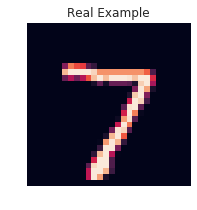

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

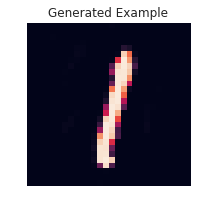

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

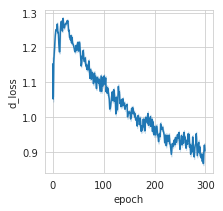

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

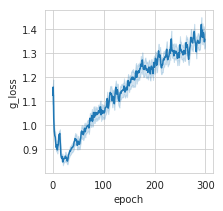

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

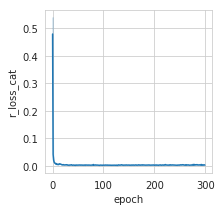

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

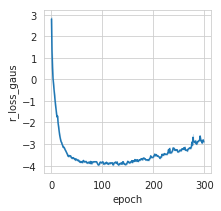

<IPython.core.display.Javascript object>

In [0]:
noise, _ = nets['G'].sample_latent(1, 'cuda')
img_fake = nets['G'](noise)
img_real = mnist_data['test'][0][0].view(1, 1, 28, 28)
pgrid = clwidgets.Grid(1, 6)
with pgrid.output_to(0, 0):
    pgrid.clear_cell()
    plt.figure(figsize=(3, 3))
    plt.imshow(img_real[0, 0].detach().cpu().numpy())
    plt.gca().set_title('Real Example')
    plt.gca().grid(False)
    plt.gca().set_axis_off()
with pgrid.output_to(0, 1):
    pgrid.clear_cell()
    plt.figure(figsize=(3, 3))
    plt.imshow(img_fake[0, 0].detach().cpu().numpy())
    plt.gca().set_title('Generated Example')
    plt.gca().grid(False)
    plt.gca().set_axis_off()
with pgrid.output_to(0, 2):
    pgrid.clear_cell()
    plt.figure(figsize=(3, 3))
    sns.lineplot(x='epoch', y='d_loss', data=training_log)
with pgrid.output_to(0, 3):
    pgrid.clear_cell()
    plt.figure(figsize=(3, 3))
    sns.lineplot(x='epoch', y='g_loss', data=training_log)
with pgrid.output_to(0, 4):
    pgrid.clear_cell()
    plt.figure(figsize=(3, 3))
    sns.lineplot(x='epoch', y='r_loss_cat', data=training_log)
with pgrid.output_to(0, 5):
    pgrid.clear_cell()
    plt.figure(figsize=(3, 3))
    sns.lineplot(x='epoch', y='r_loss_gaus', data=training_log)

###Plot a number of random samples
Below shows 100 images, arranged into a 10x10 grid, generated by the GAN we just trained. 


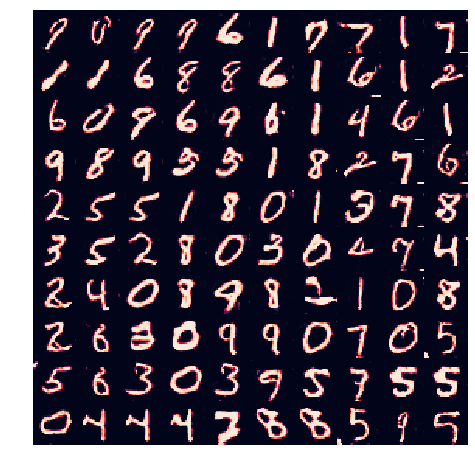

In [0]:
z = torch.randn(100, 62, 1, 1, device='cuda')
k = torch.zeros(100, 10, 1, 1, device='cuda')
k[torch.arange(100), torch.randint(0, 10, (100,))] = 1.
c = torch.stack(torch.meshgrid(torch.linspace(-1, 1, 10), torch.linspace(-1, 1, 10)), dim=2).view(100, 2, 1, 1).cuda()

with torch.no_grad():
    latc = torch.cat([z, k, c], dim=1)
    img_fake = nets['G'](latc)
    img_fake = img_fake.view(10, 10, 28, 28).permute(0, 2, 1, 3).contiguous().view(280, 280)
    img_fake = img_fake.cpu().numpy()
    plt.figure(figsize=(8, 8))
    plt.imshow(img_fake)
    plt.gca().grid(False)
    plt.gca().set_axis_off()

### Examining the categorical latent code
The 10x10 grid below shows how the continuous latent code affects the generated images. The continuous latent code has 2 dimensions, one varies from -1 to 1 along the horizontal axis and the other along the vertical axis. The noise vector $z$ is kept constant for each generation. 

The slider on top of the plot controls the 1 position in the categorical latent code.

In [0]:
@ipywidgets.interact(index=(0, 9, 1))
def generate(index):
    k.fill_(0.)
    k[:, index] = 1

    with torch.no_grad():
        latc = torch.cat([z, k, c], dim=1)
        img_fake = nets['G'](latc)
        img_fake = img_fake.view(10, 10, 28, 28).permute(0, 2, 1, 3).contiguous().view(280, 280)
        img_fake = img_fake.cpu().numpy()
        plt.figure(figsize=(8, 8))
        plt.imshow(img_fake)
        plt.gca().grid(False)
        plt.gca().set_axis_off()

interactive(children=(IntSlider(value=4, description='index', max=9), Output()), _dom_classes=('widget-interac…